In [283]:
%pylab inline

import networkx as nx
import numpy as np
import thinning
import cv2
from skimage.morphology import skeletonize_3d, skeletonize
from itertools import combinations, product
from scipy.signal import convolve2d, correlate2d

def build_graph(matrixx, node_list):
    matrix = np.copy(matrixx)

    G=nx.Graph()

    neighs = [p for p in product([-1, 0, 1], repeat=2)]
    neighs.remove((0,0))
    path_dict = {}
    
    for i, n_start in enumerate(node_list): # Main loop across graph nodes
        G.add_node(i)
        G.node[i]["coords"] = n_start
        y, x = n_start
        
        for offset in neighs: # Loop through neighbours of current node
            neigh_coords = y + offset[0], x + offset[1] # Coords on node
            if matrix[neigh_coords]:
                if neigh_coords in node_list:
                    path = [n_start, neigh_coords]
                else:
                    path = follow_path(matrix, neigh_coords, n_start, node_list)
                
                length = path_len(path)
                n_last = path[-1]
                j = node_list.index(n_last)
                if not path_dict.has_key((j,i)) and not path_dict.has_key((i,j)): 
                    G.add_node(j)
                    G.node[j]["coords"] = n_last
                    G.add_edge(i, j, weight=length, path=path)
                    path_dict[(i,j)] = path
                                    
    return G

def follow_path(mat, neigh_coords, parent, node_list):
    path = [neigh_coords]
    
    nswe_t = ((0, -1), (0,1), (-1, 0), (1,0)) 
    diag_t = ((-1, -1), (-1,1), (1, -1), (1,1))
        
    while True:
        flag = False
        # NSEW
        # these directions have the priority when following a path to another node (wrt diagonals)
        for x_offset, y_offset in nswe_t:
            new_point_coords = neigh_coords[0]+y_offset, neigh_coords[1]+x_offset
            
            if mat[new_point_coords] and new_point_coords != parent: # Pixel found
                path.append(new_point_coords)
                parent = neigh_coords
                neigh_coords = new_point_coords
                
                if new_point_coords in node_list:
                    return path
                
                flag = True
            
        if not flag:
            # Diagonal
            for x_offset, y_offset in diag_t:
                new_point_coords = neigh_coords[0]+y_offset, neigh_coords[1]+x_offset

                if mat[new_point_coords] and new_point_coords != parent: # Pixel found
                    path.append(new_point_coords)

                    parent = neigh_coords
                    neigh_coords = new_point_coords

                    if new_point_coords in node_list:
                        return path

    return []

def build_graph_marco(matrix_, node_list):
    matrix = np.copy(matrix_)
    G=nx.Graph()
    neighs = [p for p in product([-1, 0, 1], repeat=2)]
    neighs.remove((0,0)) # remove the pixel itself from the neighs
    path_dict = {}
    for i, n_l in enumerate(node_list):
        y, x = n_l
        G.add_node(i)
        G.node[i]["coords"] = n_l
        mat9 = np.copy(matrix[y-1:y+2, x-1:x+2])
        for v in neighs:
            pp = y+v[0], x+v[1] # pp contains the current neighbor coords
            if matrix[pp]>0: # is pp active?
                matrix[y-1:y+2, x-1:x+2] *= 0 # blank the whole 3x3 matrix
                matrix[pp] = 1 # turn back on JUST the current neighboring pixel
                yy, xx = pp
                path, length = follow_path_marco(matrix, pp) # follow the path until a leaf or a crossing
                dist = sqrt((n_l[0]-yy)**2 + (n_l[1]-xx)**2)
                path = [pp] + path # re add the initial path pixel
                length += dist # CAREFUL: length should be increased by 1 or sqrt(2) depending on n_l and pp
                matrix[y-1:y+2, x-1:x+2] = mat9 # fully restore the original 3x3 matrix
                if not path:
                    path = [pp] # if the path is empty just add pp
                    length = dist # and the path length

                j_list = []
                stop_list = []
                dist_list = []
                for j, p_l in enumerate(node_list[:]): # i-j and j-i to be sure paths are found reliably
                    dist = sqrt((p_l[0]-path[-1][0])**2 + (p_l[1]-path[-1][1])**2)
                    
                    if dist < 1.5: # <= sqrt(2)
                        j_list.append(j)
                        stop_list.append(p_l)
                        dist_list.append(dist)
                if j_list:
                    j_min = argmin(dist_list)
                    #print dist_list, j_min
                    if (i, j_list[j_min]) not in G.edges() and (j_list[j_min], i) not in G.edges() and i != j_list[j_min]: 
#                    if True:
                        G.add_edge(i, j_list[j_min], weight = length, path=path)
                        G.node[j_list[j_min]]["coords"] = p_l
                        path_dict[(i,j_list[j_min])] = path
                #break
        
    return G


def follow_path_marco(matrix, start):
    mat = np.copy(matrix)
    path = []
    current = start
    length = 0.
    while True:
        (y, x) = current
        mat9 = mat[y-1:y+2, x-1:x+2]
        if np.sum(mat9) < 2 or np.sum(mat9) > 2: # found another leaf / crossing
            break
        mat[current] = 0
        for r, row in enumerate(mat9):
            for c, v in enumerate(row):
                if v>0:
                    prev = current
                    current = (current[0]+r-1, current[1]+c-1)
                    dist = sqrt((prev[0]-current[0])**2 + (prev[1]-current[1])**2 ) # locally euclidean distance...
                    length += dist
                    path.append(current)
        
    return path, length


def path_len(path):
    dist = 0.0
    for seg in zip(path[:-1], path[1:]):
        x_0 = seg[0][1]
        y_0 = seg[0][0]
        x_1 = seg[1][1]
        y_1 = seg[1][0]
        dist += math.sqrt((x_0-x_1)**2.0 + (y_0-y_1)**2.0)
    return dist


def compute_diameter_path(G):
    paths = nx.all_pairs_dijkstra_path(G, weight='weight')
    dists = nx.all_pairs_dijkstra_path_length(G, weight='weight')
    longest = 0.
    nodes = (0,0)
    for i in paths:
        for j in paths[i]:
            if dists[i][j]>longest:
                longest = dists[i][j]
                nodes = (i,j)
    return longest, paths[nodes[0]][nodes[1]]
            
def smoothen(mask):
    k_size = 10
    e_size = 100
    d_size = 100
    kernel = np.ones((k_size,k_size),np.float32)/25

    erode_=(e_size,e_size)
    dilate_=(d_size, d_size)

    dst_dilation = cv2.dilate(mask, np.ones(dilate_))
    dst_erode = cv2.erode(dst_dilation, np.ones(erode_))
    dst = cv2.filter2D(dst_erode,-1,kernel)

    return dst/np.max(dst)

def create_patterns():
    combs = (list(combinations([0, 1, 2, 3, 5, 6, 7, 8], 3)))

    mat = np.zeros((len(combs)+20, 3,3)) - 1
    mat[:,1,1] = 1
    
    mat_leaf = np.zeros((9, 3,3)) - 1 # set the border to -1 and the center to 1 for all kernels
    mat_leaf[:,1,1] = 1

    # put here all "hand made" kernels
    mat[-1] = np.array([[-1,1,-1], [1,1,1], [-1,1,-1]]) # + pattern
    mat[-2] = np.array([[1,-1,1], [-1,1,-1], [1,-1,1]]) # X pattern
    
    mat[-3] = np.array([[1,-1,1], [-1,1,1], [-1,1,-1]]) # Y` pattern
    mat[-5] = np.rot90(mat[-3],1) # Y' pattern (90)
    mat[-6] = np.rot90(mat[-3],2) # Y' pattern (2X90)
    mat[-7] = np.rot90(mat[-3],3) # Y' pattern (3X90)

    mat[-4] = np.fliplr(mat[-3]) # 'Y pattern (h-flip)
    mat[-8] = np.rot90(mat[-4],1) # 'Y pattern (90)
    mat[-9] = np.rot90(mat[-4],2) # 'Y pattern (2X90)
    mat[-10] = np.rot90(mat[-4],3) # 'Y pattern (3X90)

# The following two intersections may create ghost crosses
    mat[-11] = np.array([[-1,1,-1], [1,1,-1], [-1,1,1]]) # tetris' pattern
    mat[-12] = np.rot90(mat[-3],1) # (90)
    mat[-13] = np.rot90(mat[-3],2) # (2X90)
    mat[-14] = np.rot90(mat[-3],3) # (3X90)

    mat[-15] = np.array([[-1,1,-1], [-1,1,1], [1,1,-1]]) # 'tetris pattern
    mat[-16] = np.rot90(mat[-3],1) # (90)
    mat[-17] = np.rot90(mat[-3],2) # (2X90)
    mat[-18] = np.rot90(mat[-3],3) # (3X90)
    
    # here we generate all the combinations of 3-way crosses
    for i,c in enumerate(combs):
        cmbs = list(combinations(c, 2))
        accept = True
        for (p1, p2) in cmbs:
            diff = abs(p1/3-p2/3) + abs(p1%3-p2%3)
            if diff <= 1:
                #print c, p1, p2
                accept = False
                break
        if accept:
            for n in c:
                mat[i, n/3, n%3] = 1
                
    # these 8 kernels match ending leaves
    for i in range(0,9):
        mat_leaf[i,i/3, i%3] = 1
                
    return mat, mat_leaf

def apply_convolution(matrix):    
    a = np.copy(matrix)
    res_cross = np.zeros_like(a)
    res_leaves = np.zeros_like(a)
    
    mat, mat_leaf = create_patterns()

    for k_c in mat:
        res_tmp = correlate2d(a,k_c, mode='same')
        res_tmp[res_tmp<4] = 0
        res_cross += res_tmp.astype(uint8)
    
    for k_c in mat_leaf:
        res_tmp = correlate2d(a,k_c, mode='same')
        res_tmp[res_tmp<2] = 0
        res_leaves += res_tmp.astype(uint8)
    
    return res_leaves, res_cross
        


Populating the interactive namespace from numpy and matplotlib


40.786487373185054


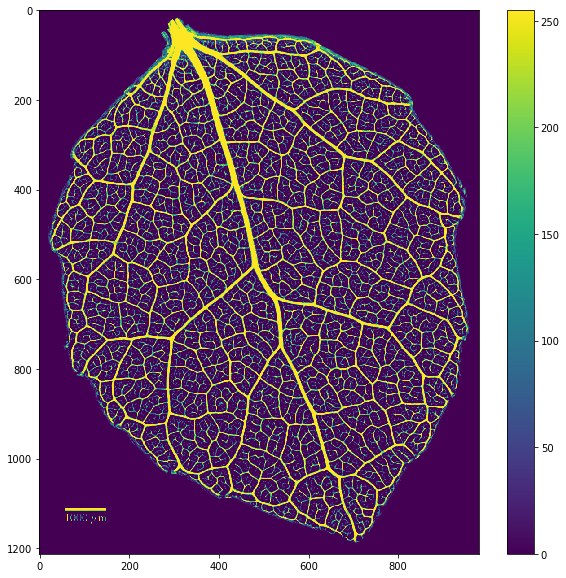

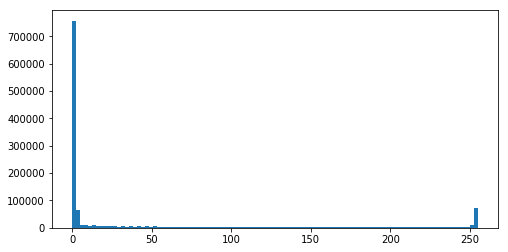

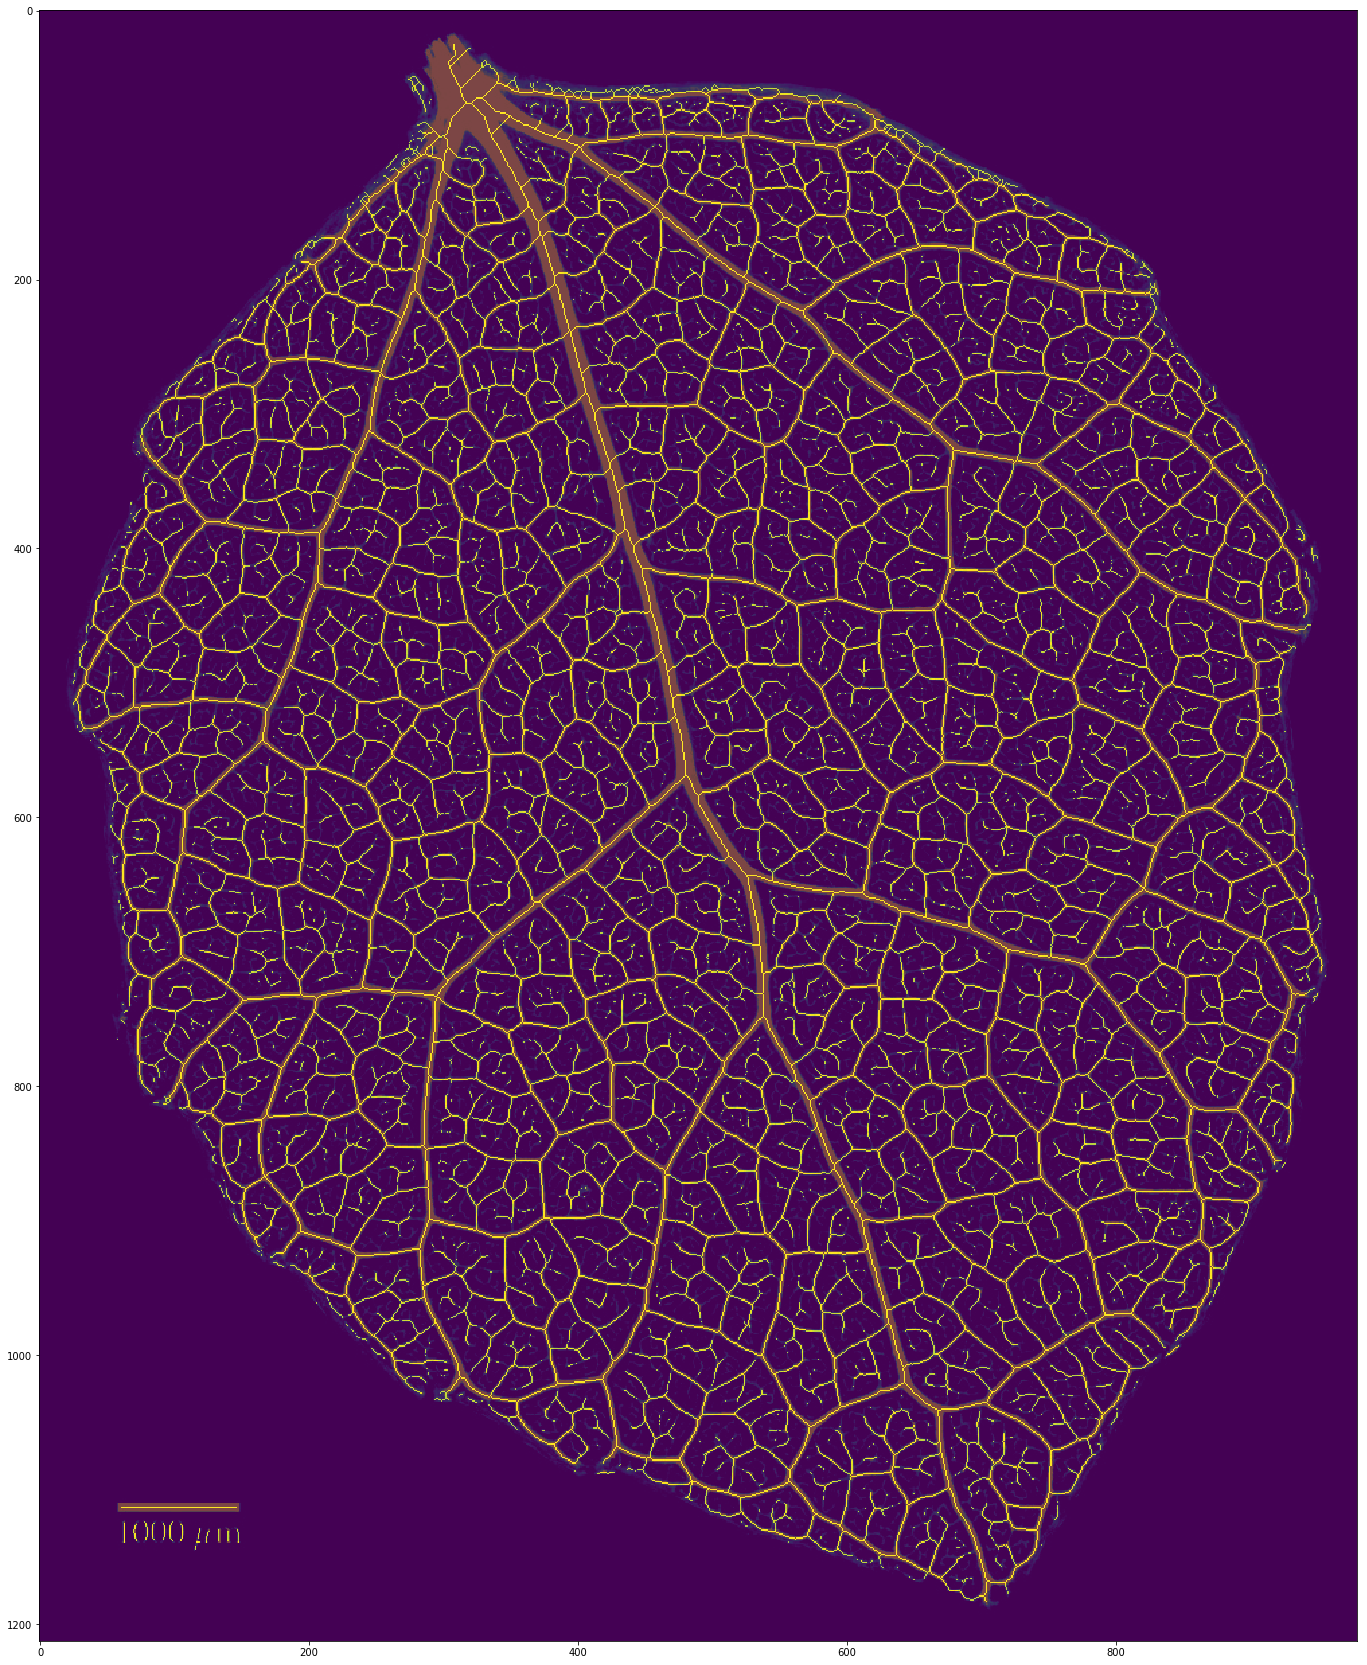

In [284]:
x = imread("/home/mcogoni/Pictures/leafBW.jpg")

#matr = np.load("/home/mcogoni/tmp/PH0156-4_core_masks.npz")
#x = matr["core_masks"][0]

#x = 1-x[400:460, 100:160,1] # just take the green channel
x = x[:, :,1] # just take the green channel

#x = x[0:200, 0:300]
x = np.pad(x, pad_width=10, mode='constant', constant_values=0)
orig = np.copy(x)

figure(figsize=(10,10))
imshow(x)
colorbar()

figure(figsize=(8,4))
hist(x.flatten(), bins=100)
print np.mean(x.flatten())

figure(figsize=(30,30))
imshow(orig)

threshold = 130 #np.mean(x.flatten())
x[orig<threshold] = 0
x[orig>=threshold] = 1

mask = np.copy(x)
#thinned = thinning.guo_hall_thinning(x.astype(uint8))

thinned = skeletonize_3d(x)
thinned /= np.max(thinned)

imshow(3*thinned, alpha=0.7) # show skeleton



"\nlength, path = compute_diameter_path(gg)\n\nprint length, path\nfor n in path:\n    p = nodes[n]\n    #print p\n    scatter(p[1], p[0], c='yellow', s=150)\n\nfor p1, p2 in zip(path[:-1], path[1:]):\n    if (p1,p2) not in path_dict:\n        (p1,p2) = (p2,p1)\n    for p in path_dict[(p1,p2)]:\n        scatter(p[1], p[0], c='green', s=20)\n\n\n    \n#print path\n\nnx.draw(gg, pos, with_labels=True)\n"

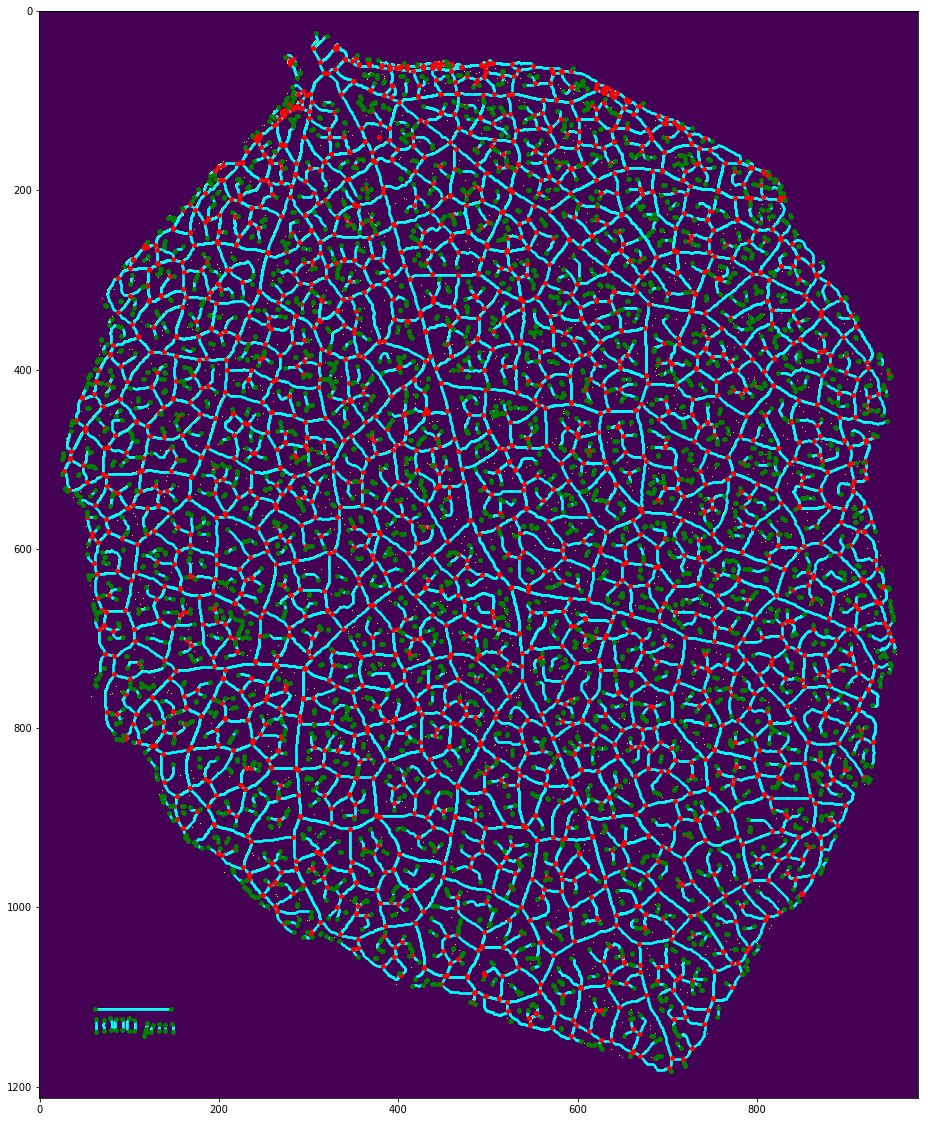

In [285]:
leaves, crosses = apply_convolution(thinned)

nodes = [(a,b) for (a,b) in zip(np.where(crosses)[0], np.where(crosses)[1])]
nodes.extend( [(a,b) for (a,b) in zip(np.where(leaves)[0], np.where(leaves)[1])] )
#print nodes, len(nodes)

gg = build_graph_marco(thinned, nodes[:])

figure(figsize=(40,20))

for ij in gg.edges():
    #print path_dict[ij]
    p = np.array(gg[ij[0]][ij[1]]["path"])
    scatter(p[:,1], p[:,0], c="cyan", s=2)
    #text(p[0,1], p[0,0], ij[0], bbox=dict(facecolor='red', alpha=0.6))
    #text(p[-1,1], p[-1,0], ij[1], bbox=dict(facecolor='red', alpha=0.6))
#    text(ij[1])
    
imshow(thinned, alpha=0.999) # show skeleton

scatter(np.where(crosses)[1], np.where(crosses)[0], c='r', s=15)
scatter(np.where(leaves)[1], np.where(leaves)[0], c='g', s=15)

#xlim(200,250)
#ylim(0,300)

#imshow(orig, alpha=0.5)


pos = {}
for i, n in enumerate(nodes):
    pos[i] = (n[1], n[0])

#for i, n in enumerate(nodes):
#    for j, m in enumerate(nodes):
#        if i == j:
#            continue
#        dist = sqrt((n[0]- m[0])**2+ (n[1]- m[1])**2 )
#        if dist < 1.5:
#            print n, m, dist
#            ggg = nx.contracted_nodes(gg, n,m)

#gg = ggg

'''
length, path = compute_diameter_path(gg)

print length, path
for n in path:
    p = nodes[n]
    #print p
    scatter(p[1], p[0], c='yellow', s=150)

for p1, p2 in zip(path[:-1], path[1:]):
    if (p1,p2) not in path_dict:
        (p1,p2) = (p2,p1)
    for p in path_dict[(p1,p2)]:
        scatter(p[1], p[0], c='green', s=20)


    
#print path

nx.draw(gg, pos, with_labels=True)
'''

In [ ]:
#fh=open("stografo.grafo",'wb')
nx.write_adjlist(gg, "stografo.grafo")

In [48]:
ij = gg.edges()[0]
gg[ij[0]][ij[1]]["path"]

[(16, 215), (17, 216), (18, 217), (19, 217)]

In [90]:
pos = {}
for i, coord in gg.nodes(data=True):
    pos[i] = coord["coords"][0], coord["coords"][1]
    
#M = gg.copy()
#while deleted:
#    deleted = False
#    for ij in M.edges():
#        dist = M[ij[0]] [ij[1]]["weight"]
#        
#        if dist < 5:
#            deleted = True
#            print ij, dist
#            M = nx.contracted_edge(M, ij, self_loops=False)
#            break

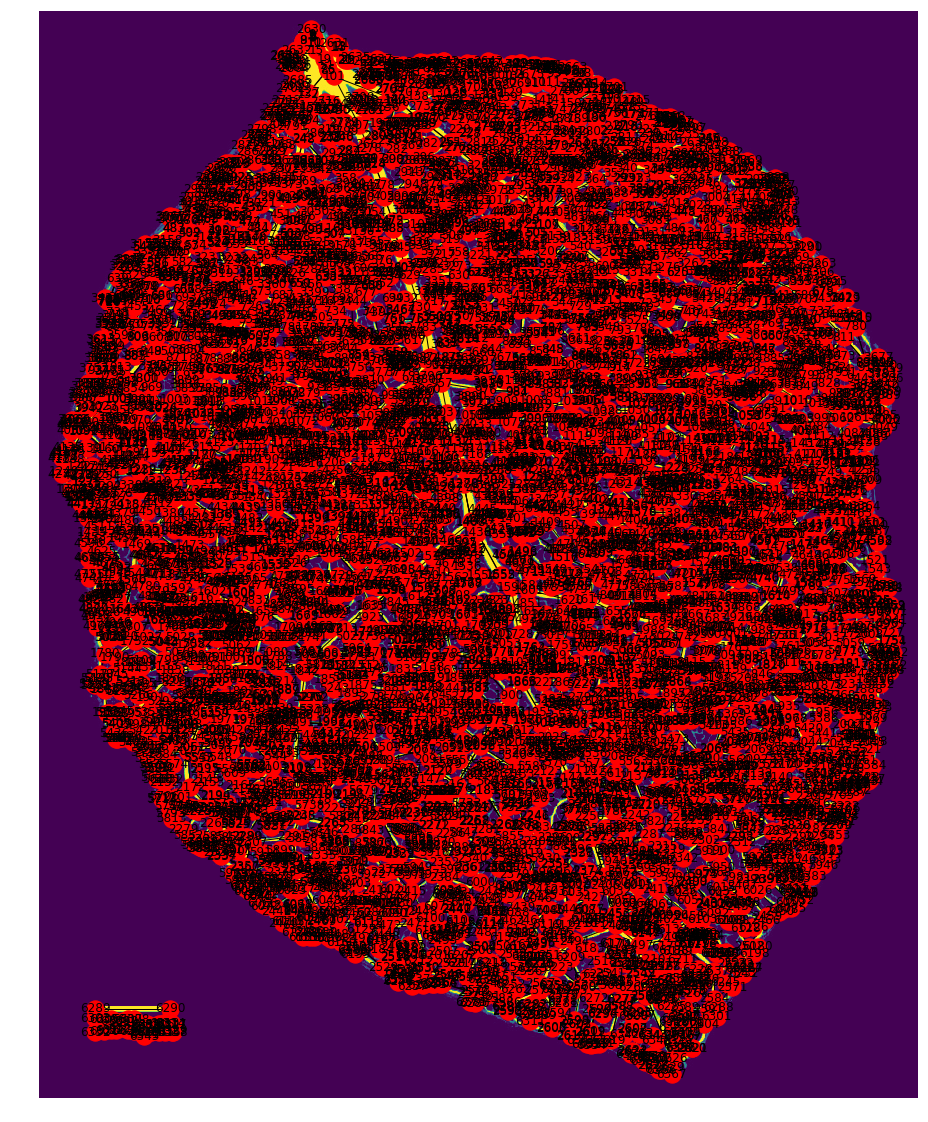

In [16]:
    
figure(figsize=(20,20))
imshow(orig)

nx.draw(gg, pos, with_labels=True)


In [59]:
m = np.zeros((10,10)).astype(uint8)

In [60]:
m[3,3] = 1
m[3,4] = 1
m[3,5] = 1
m[2,6] = 1
m[1,7] = 1


In [290]:
mat, mat_leaf = create_patterns()

#for k_c in mat:
#    res_tmp = correlate2d(a,k_c, mode='same')
#    res_tmp[res_tmp<4] = 0
#    res_cross += res_tmp.astype(uint8)

#m = np.zeros((10,10)).astype(int32)
#m[3,3] = 1
#m[3,4] = 1
#m[3,5] = 1
#m[2,6] = 1
#m[1,7] = 1


m = np.copy(thinned[0:, 0:].astype(int32))
leaves, crosses = apply_convolution(m)

nodes = [(a,b) for (a,b) in zip(np.where(crosses)[0], np.where(crosses)[1])]
for n in nodes:
#    m[n[0]-1:n[0]+2, n[1]-1:n[1]+2] = 0
    m[n] = 0
    
#m = thinned.astype(int32)
matrix_list = []
leaf_list = []
m = np.pad(m, pad_width=1, mode='constant', constant_values=0)
res_leaves = np.zeros_like(m).astype(int32)

cond = True
iteration = 0
old_sum = 100000000000000
while (np.sum(m) < old_sum  or iteration==0) or iteration<20:
    print iteration,
    old_res = np.copy(res_leaves)
    res_leaves = np.zeros_like(m)
    for k_c in mat_leaf:
        m_ones = m/m
        res_tmp = correlate2d(m_ones,k_c, mode='same')
        res_tmp[res_tmp<2] = 0
        res_tmp[res_tmp>2] = 0
        res_tmp[res_tmp==2] = 1
        
        res_leaves += res_tmp.astype(int32)
    idx = np.where(res_leaves>0)
    
    if iteration == 0:
        res_leaves[idx] *= (idx[0]*10000+idx[1]).astype(int32)
    else:
        res_leaves[idx] = np.add(old_res[idx], old_res[idx[0]+0, idx[1]+1] +old_res[idx[0]+1, idx[1]+0]
        +old_res[idx[0]-1, idx[1]+0]
        +old_res[idx[0]+0, idx[1]-1]
        +old_res[idx[0]+1, idx[1]+1]
        +old_res[idx[0]-1, idx[1]-1]
        +old_res[idx[0]+1, idx[1]-1]
        +old_res[idx[0]-1, idx[1]+1] )
        
    matrix_list.append(np.copy(m))
    leaf_list.append(res_leaves)
    m -= res_leaves/res_leaves
    iteration += 1
    #figure(figsize=(12,12))
    #imshow(res_leaves)
    old_sum = np.sum(m)


0

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in divide
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in divide


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


In [255]:
print m.shape
print res_leaves.shape
print np.max(idx[0]), np.max(idx[1])

print idx[1]+1

(1215, 982)
(1215, 982)
1188 957
[292 324 356 ... 722 713 708]


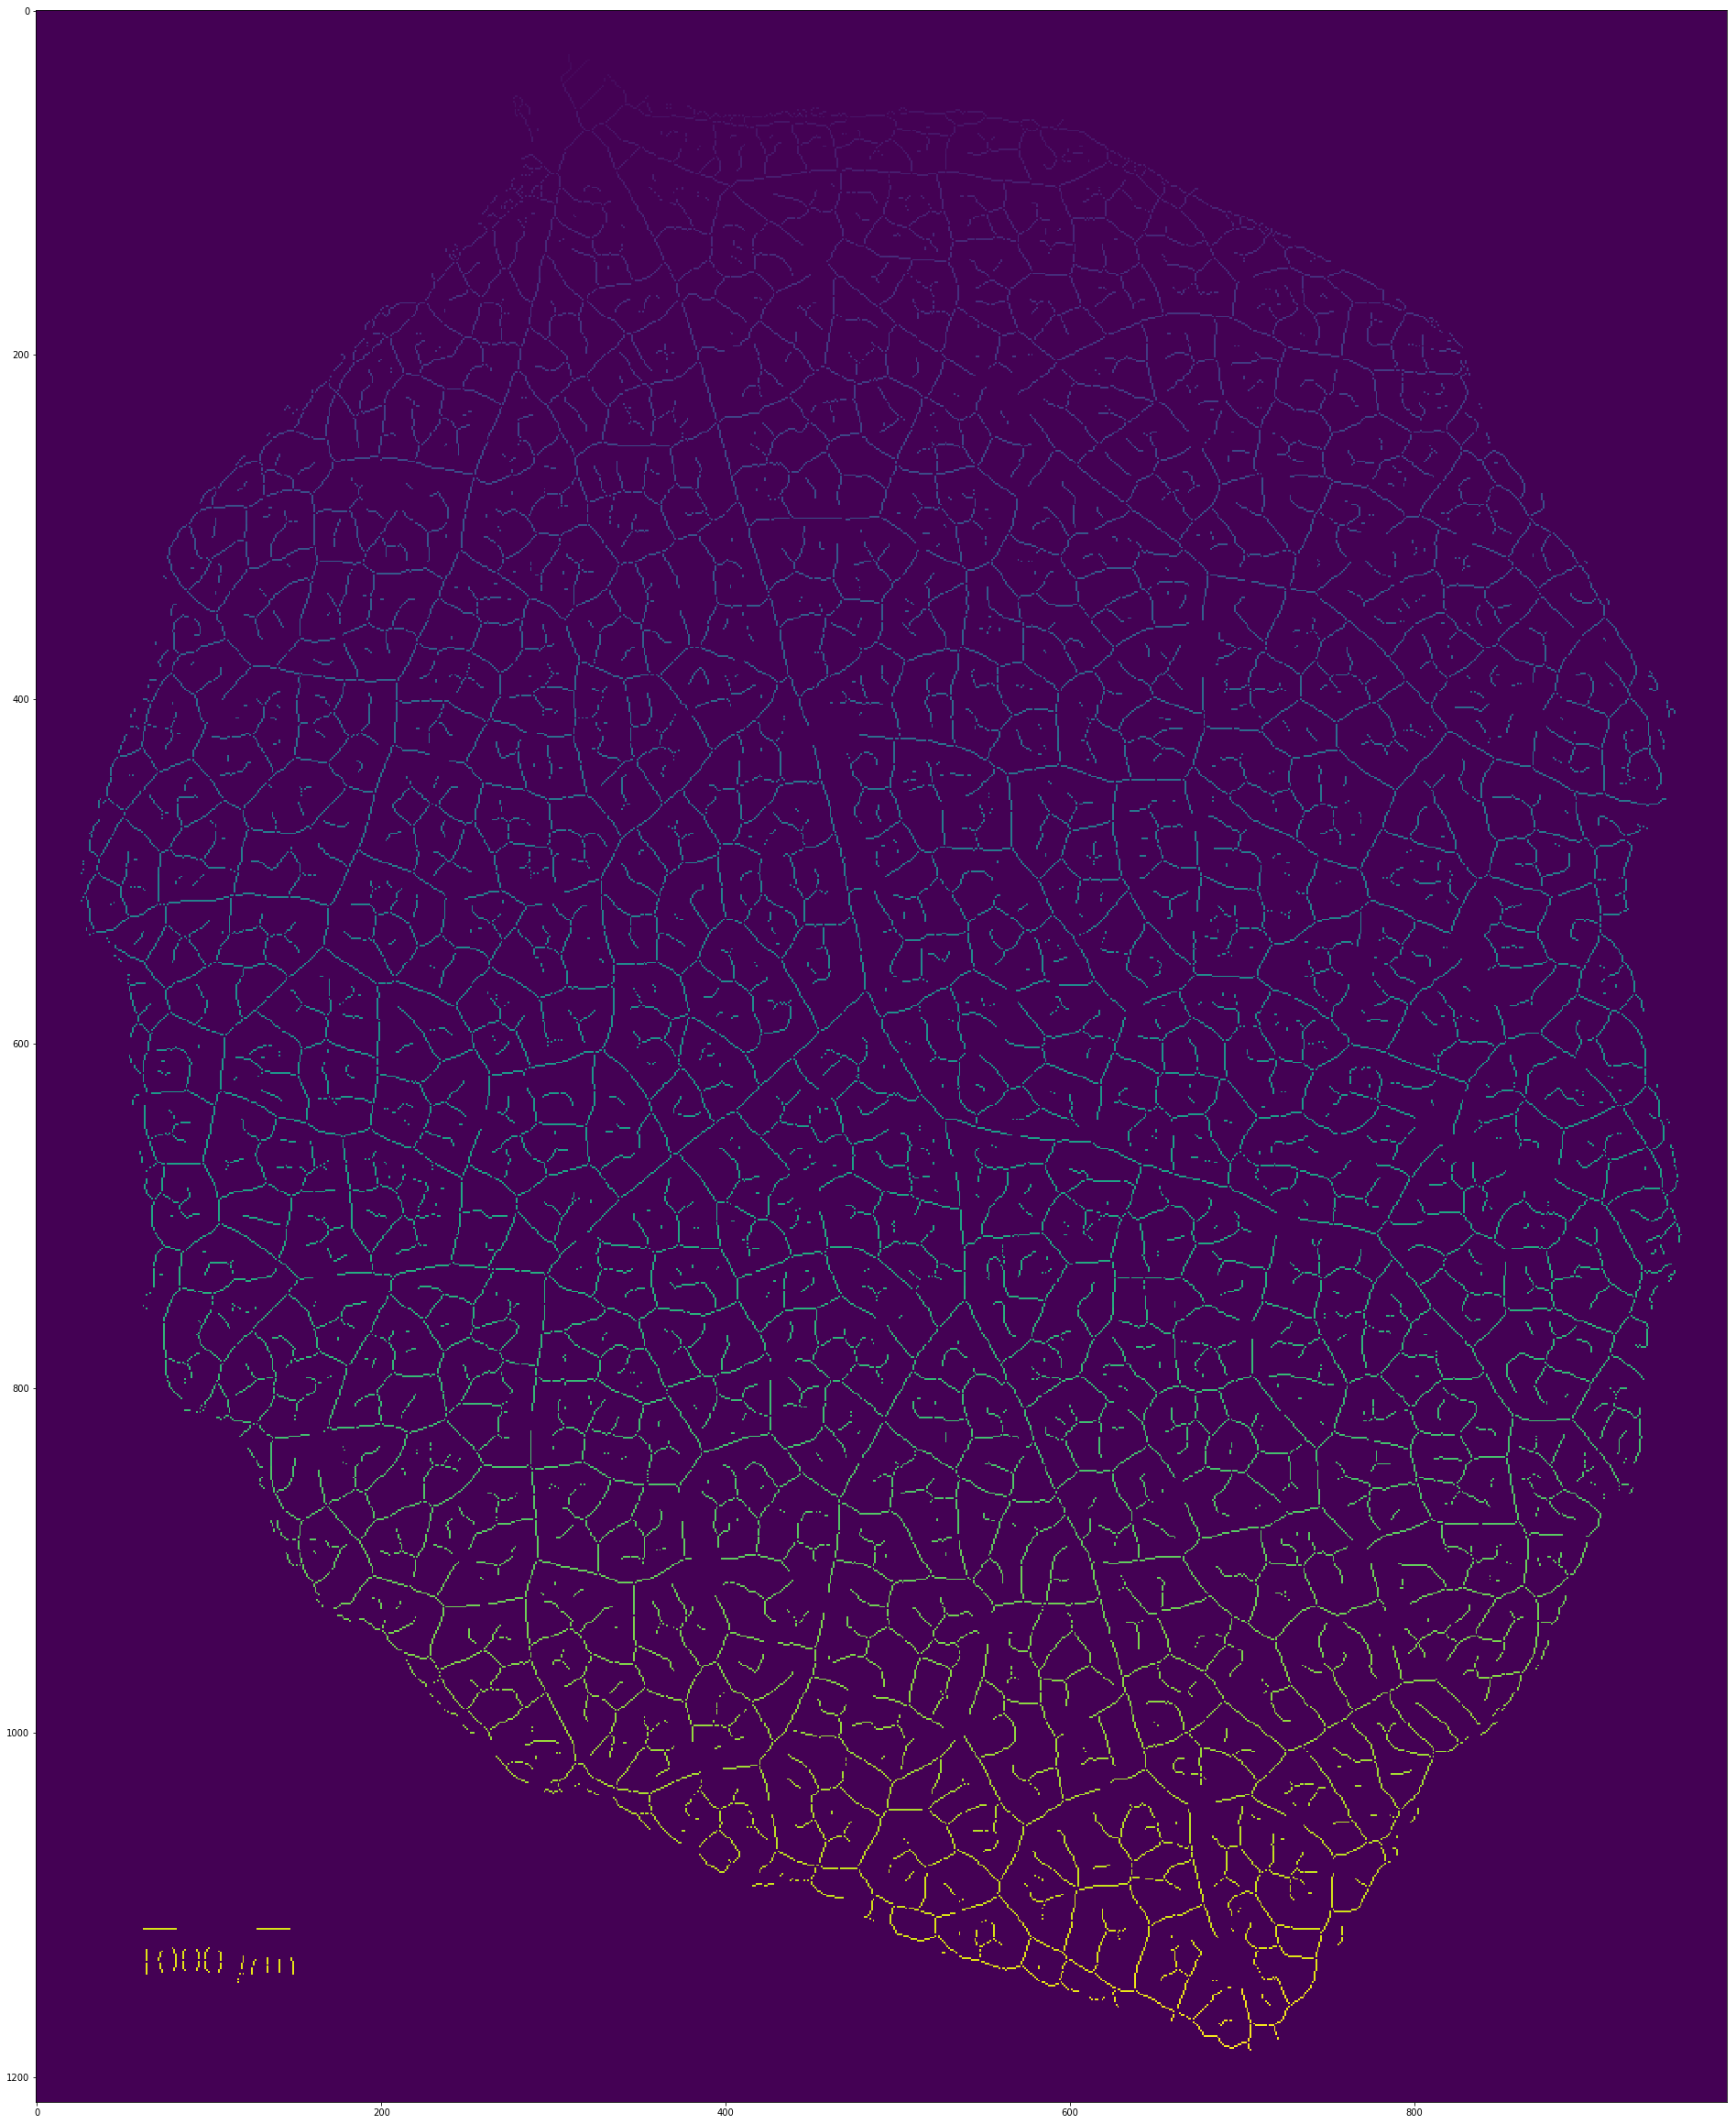

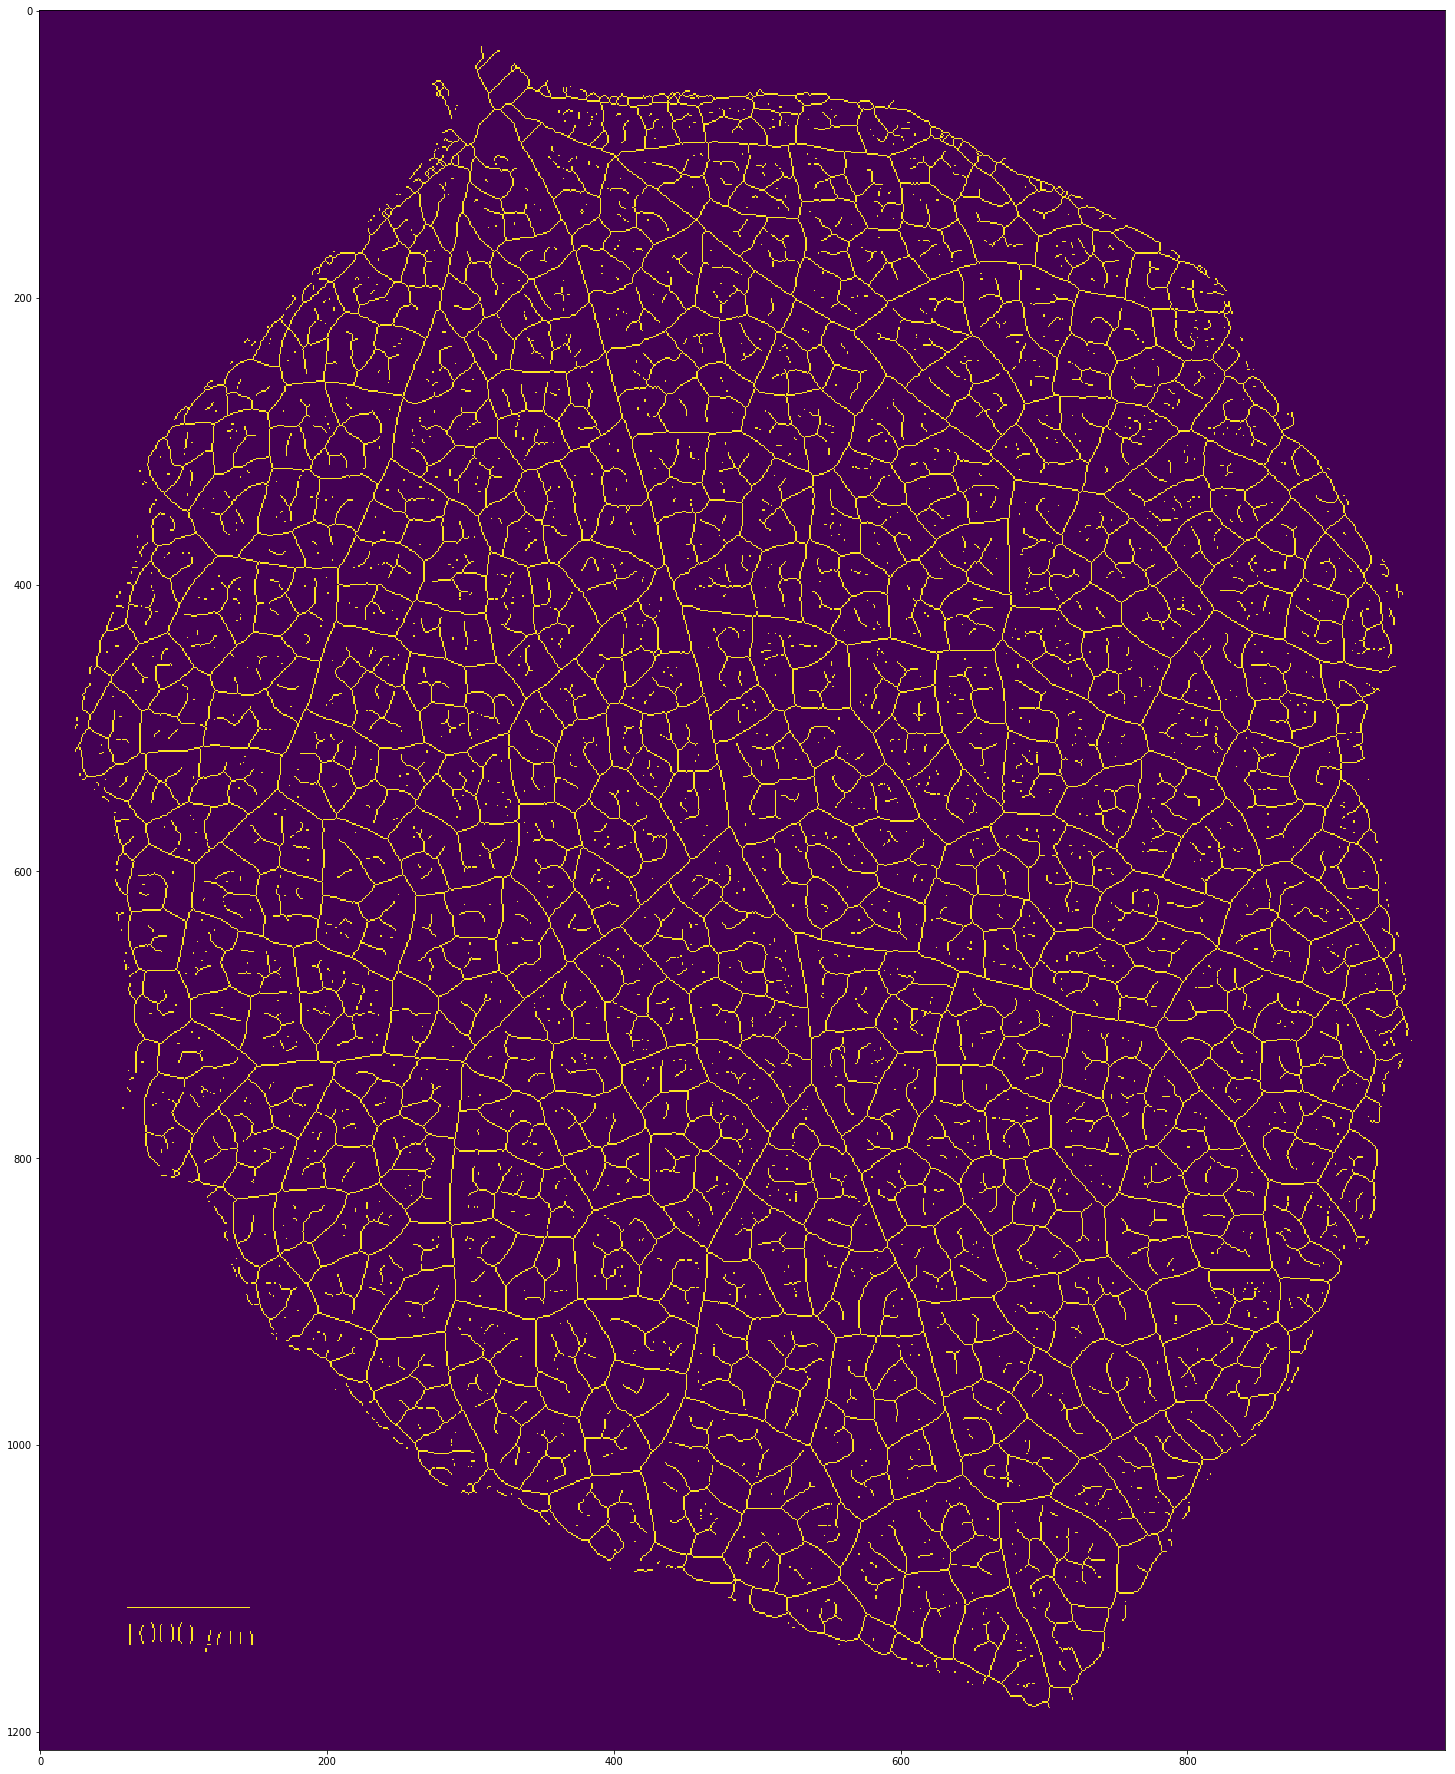

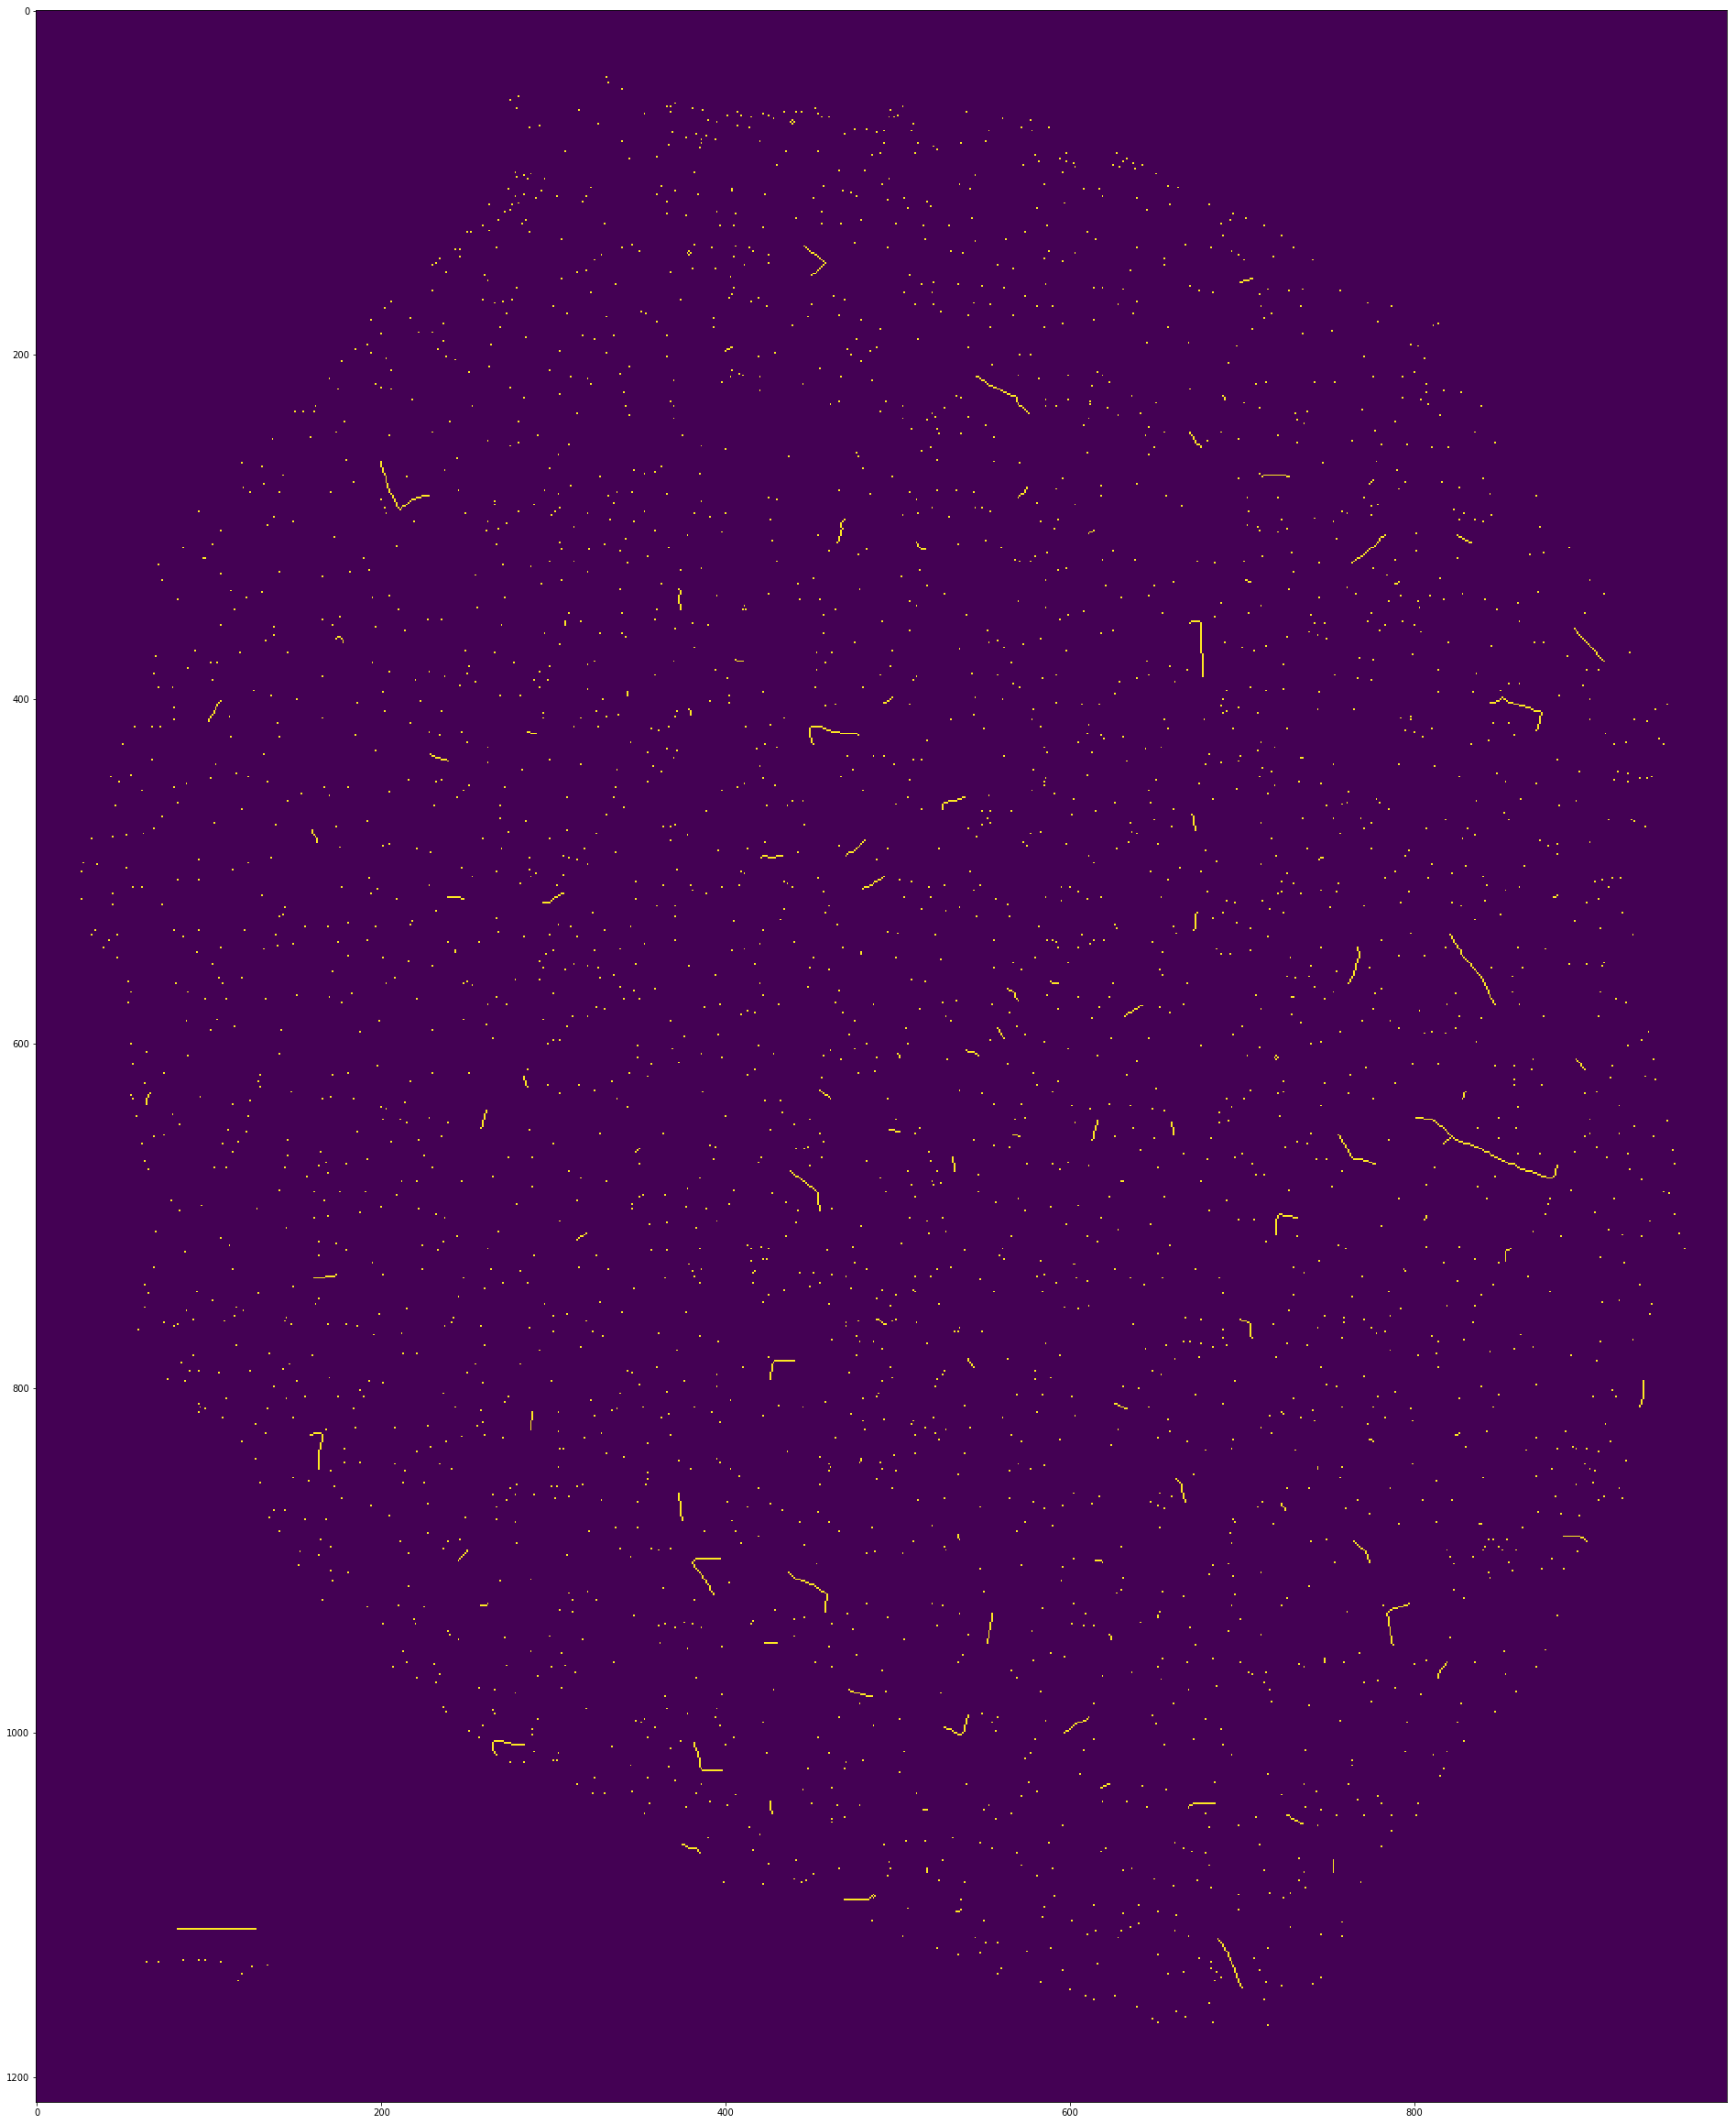

In [291]:
figure(figsize=(42,42))
imshow(np.sum(leaf_list, axis=0))

figure(figsize=(32,32))
imshow(thinned)
figure(figsize=(42,42))
imshow(m)

In [270]:
print np.sum(leaf_list, axis=0)[192:200, 192:200]

[[      0       0       0       0       0       0       0       0]
 [      0       0       0       0       0       0       0       0]
 [1920190       0       0       0       0       0       0 1970196]
 [1970194       0       0       0       0       0 1970196       0]
 [      0 1970194       0       0       0 1970196       0       0]
 [      0       0 1970194       0 1970196       0       0       0]
 [      0       0       0       0       0       0       0       0]
 [      0 1990193       0       0       0       0       0       0]]
